# AY 250 Final Project : Simulating Drag Force and Torque Using Ray Tracing

### Sam Badman - 4/28/18

In [1]:
# Import all modules required in this notebook
%matplotlib inline
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D,art3d
import ray_tracer as rt
import pickle
from ipywidgets import interact

__Introduction__

In this project, I use a ray tracing technique to calculate the drag force and drag torque experienced by a solid object composed of a series of triangular planes, sitting in a uniform fluid flow in the molecular free-streaming regime. The application of this is for the modelling of drag force and disturbance torques for the orbital and attitude modelling of a cubesat project.

The code for this project is located in the module: 
> ray_tracer.py

__Step 1 : Building the solid body__

First I construct a solid body as series of finite triagular planes. Each triangle is defined by 3 3D points. I generate these manually with a specficic shape corresponding to the features of the cubesat I work on. The units of all coordinates in this project are expressed in U which is the standard cubesat dimensions: 1U = 10cm. 

The solid consists of a 3Ux1Ux1U box (the spacecraft bus) and 2 3Ux3U solar panels which are parallel to the 1Ux1U top face of the box. The coordinate system is centered at the center of the box, which is where I assume the center of mass of the box to be. 

The long axis of the bus is aligned with the z axis, the solar panels lie in the xy plane at z=1.5 and are ajoined to the box along the $y=\pm \frac{1}{2}$ lines.

The series of vertices for the triangular planes which make up this object are produced with the function
```python
>>> ray_tracer.get_shape()
```
Each rectangular face is broken up into 2 triangles.

Below, I visualize this shape:

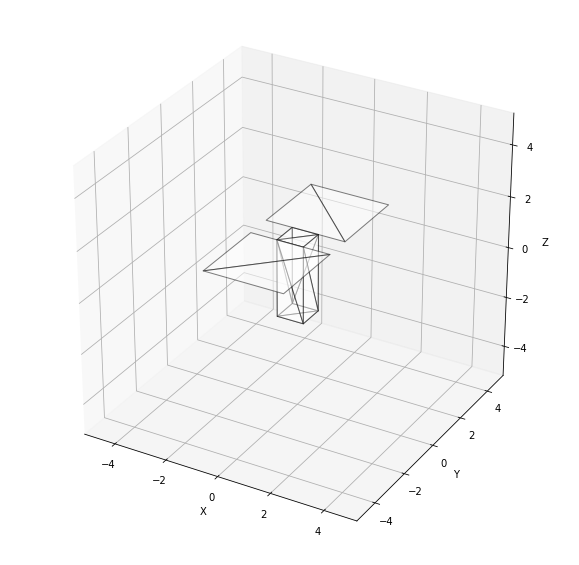

In [2]:
# Get vertices of triangular faces
tripoint_arr = rt.get_shape()

# Plot
f = plt.figure(figsize=(10,10))
ax=plt.subplot(projection='3d')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        tri.set_facecolor('white')
        ax.add_collection3d(tri)       

__ Step 2 - Initialize Ray Plane__

Next, we introduce the ray tracing method for determining drag force and drag torque. We model the fluid flowing past the spacecraft as being a series of parallel rays emanating from a finite plane. The normal vector of the plane is the same as the relative velocity vector of the spacecraft travelling through the atmosphere.

This unit vector is parameterised by a rotation about the $-y$ axis of angle $\epsilon$ (elevation),followed by a rotation about the $z$ axis of angle $\phi$ (azimuth). The elevation angle is defined between $(-90^o,90^o)$ and the azimuth angle is defined between $(0^o,360^o)$.

The finite plane is initialized in the $y$-$z$ plane $(\epsilon,\phi)=(0,0)$ so that the center point of the plane lies along the $x$-axis from the center of the spacecraft. The rays are then initialized in unit increments from this center point out to the finite extent of the plane. The center point of the plane must be at least as far as the furthest vertex of the spacecraft from the origin, and the finite extent of the plane must be at least as large as the largest vertex-vertex separation of the spacecraft. Once the plane is initialized in the $y$-$z$ plane, all the points are rotated.

This plane is produced with the function :

```python
>>> ray_tracer.ray_coords
```

The plane can be visualised, and the rotation understood in the widget below:

In [3]:
# Number of rays in the y-direction
Ny = 20
# Number of rays in the z-direction
Nz = 20
# Center of ray plane should be > furtherst vertex of shape
rc=1.*max(npl.norm(rt.get_shape(),axis=1).flatten())
# y extent of the ray plane
yp = 2.0*rc
# z extent of the ray plane
zp = 2.0*rc

def update_rayplane(az=0,el=0) :
    # Get ray plane points
    rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)
    # Get spacecraft shape for reference
    tripoint_arr = rt.get_shape()
    #Initialize plot
    f = plt.figure(figsize=(10,10))
    ax=plt.subplot(projection='3d')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])
    # Draw Spacecraft
    for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        tri.set_facecolor('white')
        ax.add_collection3d(tri)
    # Draw ray plane
    ax.scatter(rp[:,0],rp[:,1],rp[:,2])

interact(update_rayplane,az=(0,360,10),el=(-90,90,10))

interactive(children=(IntSlider(value=0, description='az', max=360, step=10), IntSlider(value=0, description='el', max=90, min=-90, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.update_rayplane>

__Step 3 - For a given ray, find closest intersection with spacecraft plane__

This is where the bulk of the computation occurs in this problem. The mathematics follows the work in chapter 9 of [Nicholas (2013)](http://ssl.mit.edu/files/website/theses/SM-2013-NicholasAustin.pdf). Each ray is initially a finite line which goes between it's starting point ($\boldsymbol{r_a}$) in the ray plane, and it's reflection through the origin ($\boldsymbol{r_b}$). Points on this line satisfy the parametric equation:

$$
\boldsymbol{r_a} + (\boldsymbol{r_b} - \boldsymbol{r_a})t = 0,\hspace{3mm} t \in [0,1]
$$

Each triangular plane is specified by 3 vectors : $\boldsymbol{r_0},\boldsymbol{r_1},\boldsymbol{r_2}$ and points in this plane satisfy the parametric equation :

$$
\boldsymbol{r_0} + (\boldsymbol{r_1} - \boldsymbol{r_0})u + (\boldsymbol{r_2} - \boldsymbol{r_0})v =  0, \hspace{3mm} u,v \in [0,1], u+v \le 1
$$

The intersections of the line and the plane are found by equating and solving these two equations, which can be written in the matrix form:

$$
(\boldsymbol{r_a} - \boldsymbol{r_0}) = (\boldsymbol{r_a} - \boldsymbol{r_b},\boldsymbol{r_1} - \boldsymbol{r_0},\boldsymbol{r_2} - \boldsymbol{r_0})\begin{pmatrix} t \\ u \\ v \\ \end{pmatrix}
$$

and inverted for the parameters $t,u,v$ :

$$
\begin{pmatrix} t \\ u \\ v \\ \end{pmatrix} 
= \begin{pmatrix} 
    x_a - x_b & x_1 - x_0 & x_2 - x_0 \\
    y_a - y_b & y_1 - y_0 & y_2 - y_0  \\ 
    z_a - z_b & z_1 - z_0 & z_2 - z_0 \\ 
   \end{pmatrix}^{-1}
   \begin{pmatrix}
   x_a - x_0 \\
   y_a - y_0 \\
   z_a - z_0 \\
   \end{pmatrix}
$$

For a given ray, we perform this computation for every plane in the solid body description. If $(t,u,v)$ simulataneously satisfy all the constraints on them listed above, then the line and plane in question intersect. If multiple planes intersect the same ray, then the one with the smallest value of $t$ is chosen, because $t$ increases from 0 as the ray travels out from it's starting point, so the intersection with the lowest $t$ is the plane the ray intersects first. 

We visualize this with the below widget which allows the plane to be moved as above, but now we can choose a particular ray and look for intersections. If it intersects, we plot the line up to the point of intersection, and highlight in red the surface element it hits.

In [4]:
import numpy.linalg as npl

def update_plot(ray_ind=int((Ny)*(Nz)/2.-10),az=30,el=-30) :    
    face_number,r_int,source = rt.compute_intersections(ray_ind = ray_ind, az = az,
                                                    el = el, yp = yp, zp = zp,
                                                    Ny = Ny, Nz = Nz, rc = rc 
                                                    )

    rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)

    tripoint_arr = rt.get_shape()

    f = plt.figure(figsize=(10,10))
    ax=plt.subplot(projection='3d')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])
    face_count = 0
    for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        if face_number != '' :
            if face_count == face_number : tri.set_facecolor('red')
            else : tri.set_facecolor('white')
        else : tri.set_facecolor('white')
        ax.add_collection3d(tri)
        face_count += 1
    ax.scatter(rp[:,0],rp[:,1],rp[:,2])
    ax.plot([rp[ray_ind,0],r_int[0]],[rp[ray_ind,1],r_int[1]]
           ,[rp[ray_ind,2],r_int[2]],color='black',linewidth=3)
    ax.scatter(r_int[0],r_int[1],r_int[2],marker='.',s=400,color='red')
    if face_number == '' : ax.text3D(-3,2,3,'No Intersection',fontsize=20)
    #ax.view_init(0,-90)
    plt.show()
    
interact(update_plot,ray_ind = (0,(Ny+1)*(Nz+1),1),az=(0,360,10),el=(-90,90,10))

interactive(children=(IntSlider(value=190, description='ray_ind', max=441), IntSlider(value=30, description='az', max=360, step=10), IntSlider(value=-30, description='el', max=90, min=-90, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.update_plot>

__ Step 4 - Iterate Over All Rays and Calculate Total Force and Torque__

Next we compute the intersections for all rays. For every ray that intersects a plane, we add a force element to the total force vector. To do this,we assume diffuse reflection so that the momentum imparted to the surface is provided parallel to the direction of the incoming ray. Therefore all force elements for a given ray are parallel. We use the following expression (eq 2.2 from this [NASA monograph](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19710016459.pdf)) to multiply each ray element by to get a force element in newtons for each ray. Here, I denote the unit vector of the ray as $\boldsymbol{\hat{r}}$ and the outward facing unit vector of the intersected face as $\boldsymbol{\hat{n}}$.

$$
\boldsymbol{dF_i} = \rho v^2(\boldsymbol{\hat{r}}\cdot\boldsymbol{\hat{n}})dA((2-\sigma_n)\boldsymbol{\hat{n}} + \sigma_t( (\boldsymbol{\hat{r}}\cdot\boldsymbol{\hat{n}})\boldsymbol{\hat{n}}-\boldsymbol{\hat{r}}) ) \\
\boldsymbol{F_D} = \sum_i \boldsymbol{dF_i}
$$

where $\sigma_n,\sigma_t$ parameterise the normal and tangential components of the momentum transfer to the surface,$v$ is the velocity of the spacecraft through the air ($~7000$km/s),$\rho$ is the atmospheric density at the spacecraft location (strongly dependent on altitude), and $dA=A/((N_y+1)(N_z+1))$ is the flow area corresponding to each ray from the ray plane. 

From an implementation point of view, it is important to check that the plane normal vector is outwards from the body. To do this, we take the dot product of the ray vector with the normal vector. If the dot product is negative, then this is correct, if it is positive, then the normal vector must be multiplied by -1.

Additionally for each ray intersection, we take the cross product of the corresponding force element with the intersection position, \hspace{2mm} ($\boldsymbol{r}_i$) to get the contribution to the torque, and sum these together to get the total torque:

$$
\boldsymbol{\tau}_i = \boldsymbol{r}_i \times \boldsymbol{dF_i} \\
\boldsymbol{\tau_D} = \sum_i \boldsymbol{dF_i}
$$

To perform this iteration over rays in practice, I use python's ```multiprocessing.Pool``` to run each ray in parallel to speed up computation. See the source code for ```ray_tracer.compute_drag``` for details.

Here is an example of the output of running this function to get a force and torque vector.

In [5]:
az = 40
el = 30
Ny = 20
Nz = 20
# Center of ray plane should be > furtherst vertex of shape
pts = np.array(rt.get_shape())
rc= 1.1*np.max(npl.norm(pts,axis=1).flatten())
yp = 8.0
zp = 8.0
force,torque,hits,sources,faces,n_arr=rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc,viz=True)
#hits,norm =rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc)
torque[abs(torque) < 1e-12] = 0.0

# Dimensionalize with example density:
print("Force Vector (per unit rho v^2):", force)
print("Torque Vector (per unit rho v^2):", torque)

Force Vector (per unit rho v^2): [-0.04326806 -0.03453029 -0.06266517]
Torque Vector (per unit rho v^2): [ 0.02559573 -0.0298193  -0.00372909]


And here is a visualization of the result showing all the rays which intersect the spacecraft. All surfaces which are intersected by at least 1 ray are highlighted in red.

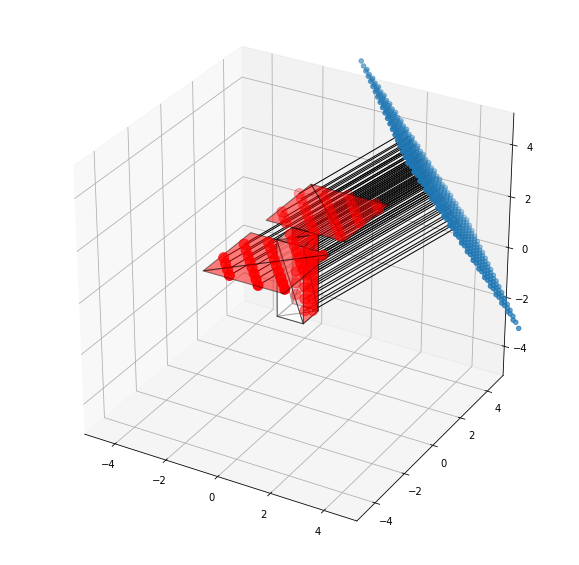

In [6]:
#Visualize hits on body
tripoint_arr = rt.get_shape()
rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)
f = plt.figure(figsize=(10,10))
ax=plt.subplot(projection='3d')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
face_count = 0
for tripoints in tripoint_arr :
    tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
    tri.set_edgecolor('k')
    if face_count in faces : tri.set_facecolor('red')
    else : tri.set_facecolor('white')
    ax.add_collection3d(tri)
    face_count += 1
ax.scatter(rp[:,0],rp[:,1],rp[:,2])
jj=0
for ii in range(len(hits)) :
    ax.plot([sources[ii,0],hits[ii,0]],[sources[ii,1],hits[ii,1]]
           ,[sources[ii,2],hits[ii,2]],color='black',linewidth=1)
ax.scatter(hits[:,0],hits[:,1],hits[:,2],marker='.',s=400,color='red')
ax.quiver(0,0,0,force[0]/100.,force[1]/100.,force[2]/100.,color='blue')
ax.quiver(0,0,0,torque[0]/100.,torque[1]/100.,torque[2]/100.,color='green')
#ax.view_init(0,180)
plt.show()

__Step 5 - Iterate Over Azimuth and Elevation Angles to Tabulate Flow Direction Dependent Drag Force and Torque__

In [8]:
#df = rt.tabulate_drag(36,18,Ny=20,Nz=20,yp=yp,zp=zp,rc=rc)
#pickle.dump(df,open("dt_tabulated.pkl","wb"))
df = pickle.load(open("dt_tabulated.pkl","rb"))

In [9]:
def update_plot(az=0,el=0) :    

    rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)

    tripoint_arr = rt.get_shape()

    f = plt.figure(figsize=(10,10))
    ax=plt.subplot(projection='3d')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])
    face_count = 0
    for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        tri.set_facecolor('white')
        ax.add_collection3d(tri)
        face_count += 1
    force,torque = df[az][el][0],df[az][el][1]
    ax.quiver(0,0,0,force[0]*100.,force[1]*100.,force[2]*100.,color='blue')
    ax.quiver(0,0,0,torque[0]*100.,torque[1]*100.,torque[2]*100.,color='green')
    ax.scatter(rp[:,0],rp[:,1],rp[:,2])
    #ax.view_init(0,-90)
    plt.show()
    
interact(update_plot,az=(0,360,10),el=(-90,90,10))

interactive(children=(IntSlider(value=0, description='az', max=360, step=10), IntSlider(value=0, description='el', max=90, min=-90, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.update_plot>

__Unit Test__ : Verify the specific drag force with a known quantity.

Let's use the flow all coming in from the +x direction. This hits the side of the spacecraft facing this direction edge on, and doesn't intersect the solar panels which are parallel to this flow. The normal and flow are exactly antiparallel. This means the force for a part of this surface area $dA$ is given by :

$$
dF  = \boldsymbol{\hat{r}}\cdot\boldsymbol{\hat{n}})dA((2-\sigma_n)\boldsymbol{\hat{n}} + \sigma_t( (\boldsymbol{\hat{r}}\cdot\boldsymbol{\hat{n}})\boldsymbol{\hat{n}}-\boldsymbol{\hat{r}}) ) \\
= -(2-\sigma_n)\boldsymbol{\hat{n}}dA \\
= 1.2 (-1, 0, 0) dA
$$

and this is identical all over this surface, so we can integrate to get the total force just by replacing $dA$ with the actual area of the face $A = 0.03 m^2$, giving a total specific force of exactly $0.036 N/kg/m/s^2$

Now, I run the drag force calculation for this configuration for different numbers of rays to see how the ray quantization affects the estimate of the area:

In [10]:
az = 0
el = 0
yp = 8.0
zp = 8.0
rc= 1.1*np.max(npl.norm(pts,axis=1).flatten())
#fx = []
fx_true = 0.036
Ns = [10 + 2*i for i in range(18)]
#for N in Ns :
#    Ny = N
#    Nz = N
#    force,torque=rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc)
#    fx.append(abs(force[0]))
#pickle.dump([Ns,fx],open("fx_unit_test.pkl","wb"))
[Ns,fx] = pickle.load(open("fx_unit_test.pkl","rb"))

Text(0,0.5,'Calculated drag force [N/kg/m/s^2]')

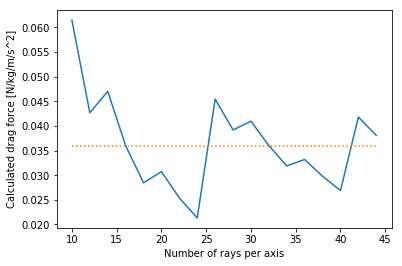

In [11]:
plt.plot(Ns,fx)
plt.plot(Ns,[fx_true]*len(Ns),linestyle=':')
plt.xlabel('Number of rays per axis')
plt.ylabel('Calculated drag force [N/kg/m/s^2]')

Repeat the same analysis with the top surface, which should have a true value of $0.228 N/kg/m/s^2$ directed in the -z direction :

In [12]:
az = 0
el = 90
yp = 8.0
zp = 8.0
rc= 1.1*np.max(npl.norm(pts,axis=1).flatten())
#fz = []
fz_true = 0.228
Ns = [10 + 2*i for i in range(18)]
#for N in Ns :
#    Ny = N
#    Nz = N
#    force,torque=rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc)
#    fz.append(abs(force[2]))
#pickle.dump([Ns,fz],open("fz_unit_test.pkl","wb"))
[Ns,fz] = pickle.load(open("fz_unit_test.pkl","rb"))

Text(0,0.5,'Calculated drag force [N/kg/m/s^2]')

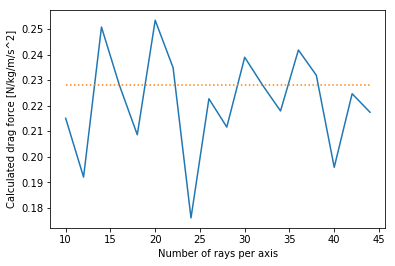

In [13]:
plt.plot(Ns,fz)
plt.plot(Ns,[fz_true]*len(Ns),linestyle=':')

plt.xlabel('Number of rays per axis')
plt.ylabel('Calculated drag force [N/kg/m/s^2]')

As can be seen, the results tend to fluctuate about the true value with an error of approximately $20\%$. This error is coming from the rays intersecting near the edges of the faces. Sometimes the rays just intersect, and sometimes they just miss, leading to an overestimate and underestimate of the force respectively. 

Future work should be done to account for this. One way is to add more rays, however this will computationally costly. Alternatively, multiple runs could be done with different ray numbers and the answer averaged. Finally, the ray mesh could be staggered so each row is a half unit misaligned from the one above and below. This should mean the edge effects average out.